# Test case B: Continuous optimization of the source and receiver position

In [24]:
import numpy as np
from jax import jit, vjp
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *


In [25]:
N = (32, 32)  # Grid size
# dx = (0.1, 0.1)  # Spatial resolution
dx = (1.0, 1.0)  # Spatial resolution
f = 400
omega = 2*jnp.pi*f  # Wavefield omega = 2*pi*f

# Defining the domain
domain = Domain(N, dx)

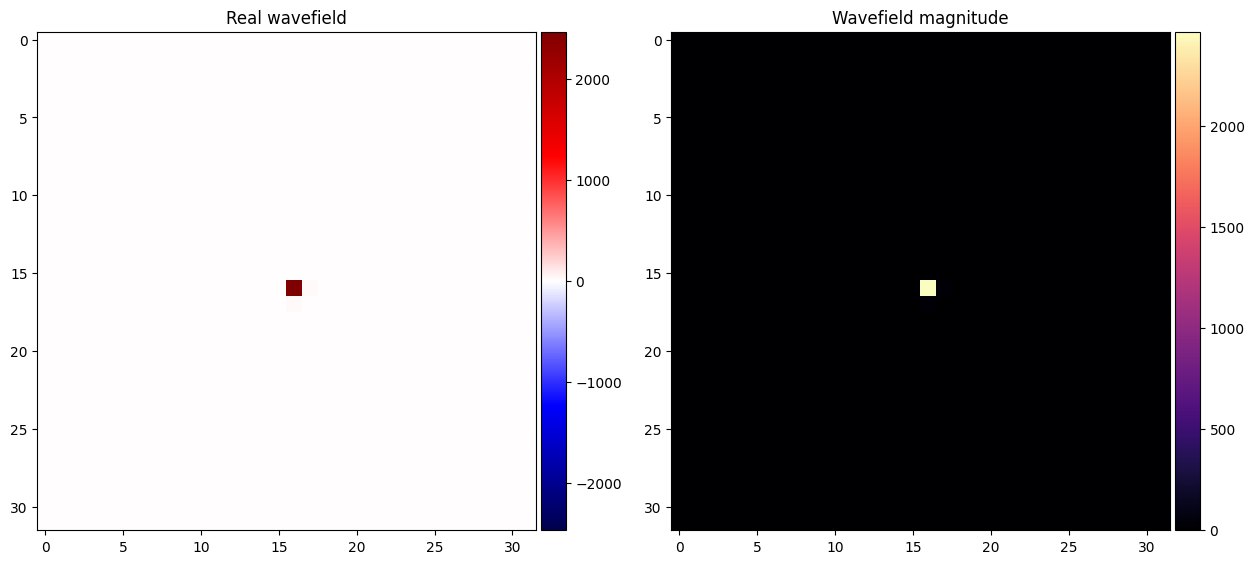

In [26]:
x = N[0]//2 + 0.01
y = N[1]//2 + 0.01
src_coord = jnp.array([[y, x]]).astype(jnp.float32)
# receiver_coords = jnp.array([[8.1, 28.1]]).astype(jnp.float32)
# receiver_coords = jnp.array([[8.1, 2*28.1]]).astype(jnp.float32)

# many receivers
receiver_coords = jnp.array([[8.1, 0.125*N[1]+0.1]]).astype(jnp.float32)

# receiver_coords = jnp.array([[8.1, 0.125*N[1]+0.1],[8.1, 0.25*N[1]+0.1], [8.1, 0.5*N[1]+0.1], [8.1, 0.75*N[1]+0.1], [8.1, 0.90*N[1]+0.1],]).astype(jnp.float32)

src = create_src_field(N, src_coord[0][0], src_coord[0][1], domain, omega)

# Plotting
_ = display_complex_field(src)

(500, 1, 70, 70)


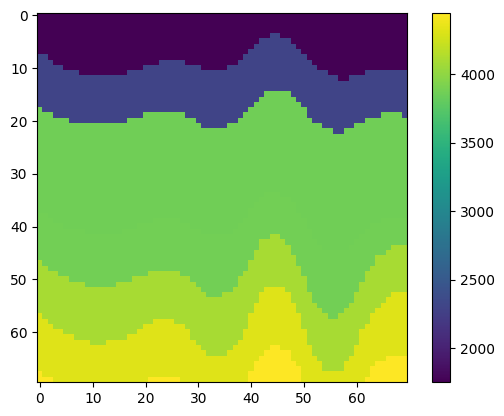

(500, 1, 32, 32)


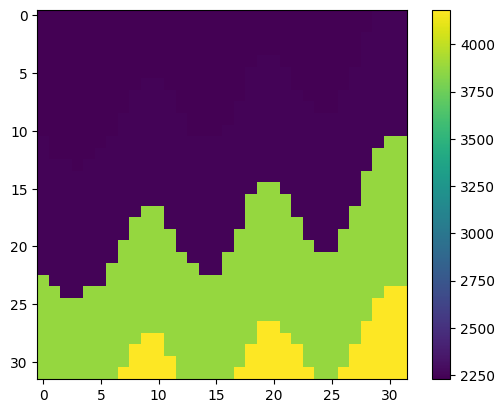

In [31]:
# load data1.npy
model = np.load('model1.npy')
print(model.shape)

plt.imshow(model[70,0,:,:])
plt.colorbar()
plt.show()

# downsample to 32 by 32
model = model[:,:,6::2,6::2]
print(model.shape)

plt.imshow(model[4,0,:,:])
plt.colorbar()

In [6]:
# Constructing medium physical properties
sound_speed = jnp.zeros(N)

density = 1000.  # sound_speed*0 + 1.
attenuation = 0.0  # density*0

# sound_speed = jnp.full(N, 1540.)
sound_speed = jnp.array(model[4,0,:,:])

pml_size = 15

# make a square in the middle of the domain
# sound_speed = sound_speed.at[N[0]//3:N[0]//3+8, N[1]//3:int(N[1]//4 * 2.5)].set(1000.)



true_medium = Medium(domain=domain, sound_speed=sound_speed,pml_size=pml_size)

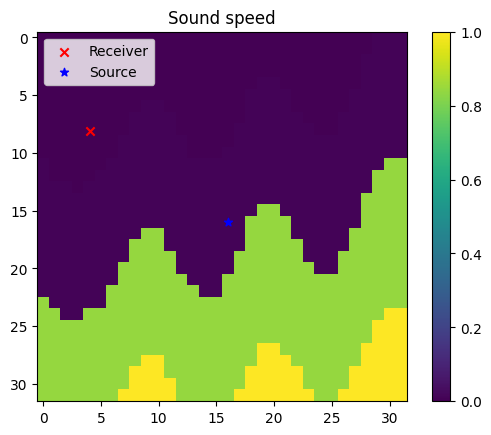

In [7]:
# plot the medium
plt.figure()
plt.imshow(true_medium.sound_speed.on_grid)
# add the receiver position
# plot all the receivers

plt.scatter(*receiver_coords.T[::-1], color='r', marker='x')

# plt.scatter(*receiver_coords[0][::-1], color='r', marker='x')
plt.scatter(*src_coord[0][::-1], color='b', marker='*')
plt.colorbar()
plt.title("Sound speed")
plt.legend(["Receiver", "Source"], loc='upper left')
plt.show()

In [10]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

@jit
def solve_helmholtz_general(sound_speed, src_coord, omega):
    src = create_src_field(N, src_coord[0], src_coord[1], domain, omega)
    medium = Medium(domain=domain, sound_speed=sound_speed, density=1000., pml_size=pml_size)
    field = helmholtz_solver(medium, omega, src)
    return field.on_grid.squeeze()

In [12]:
true_field = solve_helmholtz_general(sound_speed, [y,x], omega)

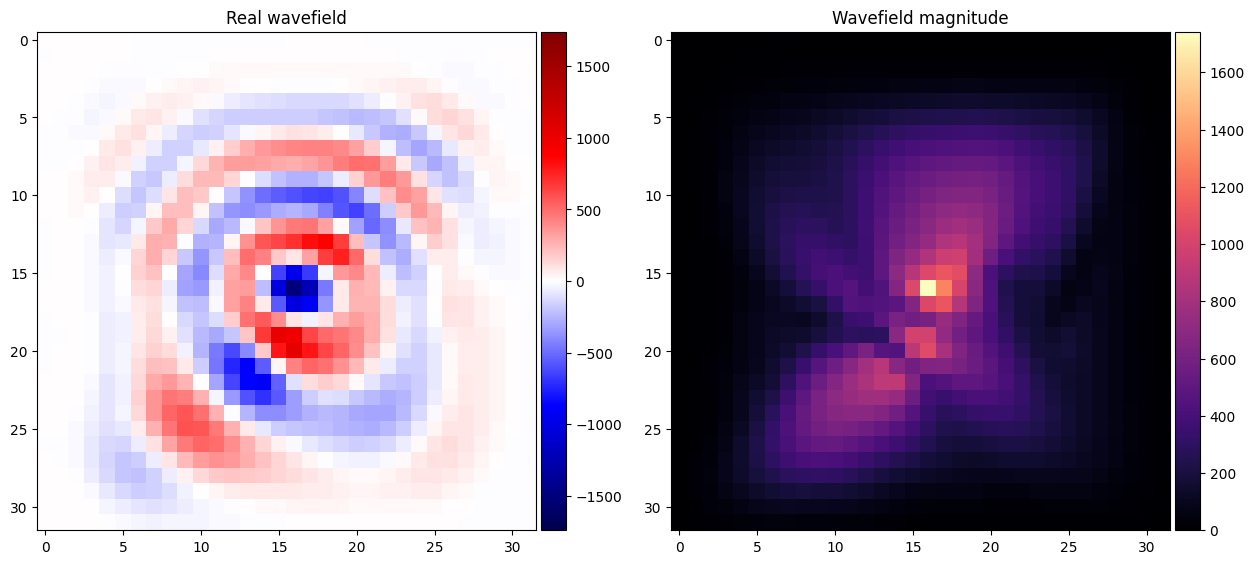

In [13]:
_ = display_complex_field(true_field)

In [ ]:
def extract_receiver_values(field, receiver_coords):
    receiver_coords = receiver_coords.astype(jnp.int32)
    return jnp.array([field[coord[0], coord[1]] for coord in receiver_coords])

def extract_receiver_values_interpolated(field, receiver_coords):
    # Assume receiver_coords is a float array
    x_floor = jnp.floor(receiver_coords[:, 0]).astype(jnp.int32)
    y_floor = jnp.floor(receiver_coords[:, 1]).astype(jnp.int32)
    x_ceil = jnp.ceil(receiver_coords[:, 0]).astype(jnp.int32)
    y_ceil = jnp.ceil(receiver_coords[:, 1]).astype(jnp.int32)

    # Interpolation weights
    wx = receiver_coords[:, 0] - x_floor
    wy = receiver_coords[:, 1] - y_floor

    # Bilinear interpolation
    top_left = field[x_floor, y_floor]
    top_right = field[x_floor, y_ceil]
    bottom_left = field[x_ceil, y_floor]
    bottom_right = field[x_ceil, y_ceil]

    interpolated_values = (
        (1 - wx) * (1 - wy) * top_left +
        wx * (1 - wy) * top_right +
        (1 - wx) * wy * bottom_left +
        wx * wy * bottom_right
    )

    # Return real and imaginary parts separately
    return jnp.real(interpolated_values), jnp.imag(interpolated_values)

def compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag
    
    jacobians_real = []
    jacobians_imag = []
    
    for src_coord in src_coords:
        # Compute VJP for the given source
        (y_real, y_imag), vjp_fn = vjp(lambda s: field_at_receivers(s, src_coord,receiver_coords, omega), sound_speed)
        
        # Calculate VJP for both real and imaginary parts
        jacobian_real = vjp_fn((jnp.ones_like(y_real), jnp.zeros_like(y_imag)))[0]
        jacobian_imag = vjp_fn((jnp.zeros_like(y_real), jnp.ones_like(y_imag)))[0]
        
        jacobians_real.append(jacobian_real)
        jacobians_imag.append(jacobian_imag)
    
    # Stack the Jacobians for each source
    return jnp.array(jacobians_real), jnp.array(jacobians_imag)

def determiant_of_approximated_hessian(Jacobian):
    """
    Compute the determinant of the approximated Hessian matrix

    Parameters:
    - Jacobian (np.ndarray): The Jacobian matrix

    Returns:
    - determinant (float): The determinant of the approximated Hessian matrix
    """
    
    # copmut the sum of all the columns
    # print("jacobian shape",Jacobian.shape)
    # return jnp.abs(jnp.sum(jnp.abs(jnp.sum(Jacobian, axis=0))))
    # return jnp.sum(jnp.abs(jnp.diag(Jacobian.T @ Jacobian)))


    # return jnp.log10(jnp.linalg.cond(Jacobian.T @ Jacobian))

    eig_vals, eig_vec = jnp.linalg.eigh(jnp.conj(Jacobian).T @ Jacobian)

    # count the number of eigenvalues that are greater than 1e-10
    # threshold = 1e-14
    # return jnp.sum(eig_vals > threshold)

    
    # return jnp.sum(jax.nn.sigmoid(8e12 * (eig_vals - threshold)))



    # return jnp.sum(jax.scipy.special.entr(jnp.real(eig_vals) / jnp.sum(jnp.real(eig_vals))))

    return jnp.log10(jnp.var(eig_vals)) + 1e-5

    # hessian =   Jacobian.T @ Jacobian
    # regularized_hessian = hessian + 0.98 * jnp.eye(hessian.shape[0])
    # return ((jnp.linalg.det(hessian)))
    # return jnp.abs(scaled_det(hessian))
    # get the largest eigenvalue
    # lambda_max, _ = power_method(hessian)
    # return -jnp.real(jnp.trace((hessian/lambda_max)))

def compute_penalty(src_coord, domain_size, penalty_weight=1.0, epsilon=1e-1):
    """
    Computes a symmetric penalty based on the distance of the source to each domain border.
    
    Parameters:
    - src_coord: The coordinates of the source (x, y).
    - domain_size: The size of the domain (N_x, N_y).
    - penalty_weight: The weight of the penalty term.
    - epsilon: A small constant to avoid division by zero.
    
    Returns:
    - penalty: The symmetric penalty value considering all borders equally.
    """
    N_x, N_y = domain_size
    x, y = src_coord[0]  # Correct access to source coordinates

    # Calculate distance to each border
    d_left = x
    d_right = N_x - x
    d_top = y
    d_bottom = N_y - y

    # Ensure distances are non-zero to avoid division by zero
    d_left = jnp.amax(jnp.array([d_left, epsilon]))
    d_right = jnp.amax(jnp.array([d_right, epsilon]))
    d_top = jnp.amax(jnp.array([d_top, epsilon]))
    d_bottom = jnp.amax(jnp.array([d_bottom, epsilon]))

    # d_right = jnp.max(d_right, epsilon)
    # d_top = jnp.max(d_top, epsilon)
    # d_bottom = jnp.max(d_bottom, epsilon)

    # Compute penalties for each border
    penalty_left = penalty_weight / d_left
    penalty_right = penalty_weight / d_right
    penalty_top = penalty_weight / d_top
    penalty_bottom = penalty_weight / d_bottom

    # Combine the penalties symmetrically, ensuring equal weight to each border
    total_penalty = (penalty_left + penalty_right + penalty_top + penalty_bottom) / 4.0

    return total_penalty

def objective_function(args): 

    src_coord, receiver_coords = args  
    # src_coord = args

    # delta_new_src_list = args(jnp.array(src_coord).ravel()).reshape(-1, 2)
    # print(new_src_list)
    # make sure that every value in new_src_list is a positive integer
    # delta_new_src_list = jnp.abs(delta_new_src_list)
    # new_src_list = jnp.array(src_coord) + delta_new_src_list 
    # new_src_list = new_src_list.round()
    # new_src_list = new_src_list.astype(int)

    # new_src_list = new_src_list.tolist()
    # print(new_src_list)

    # transform the args into all integers
    # print('raw arg',args)
    # args = jnp.round(args).astype(jnp.int32)
    # print('rounded args',args)

    J = compute_jacobian_at_receivers_vjp(sound_speed, src_coord, omega, receiver_coords)



    # plt.figure()
    # plt.imshow(jnp.real(J[0]))
    # plt.colorbar()
    # plt.title("Jacobian")
    # plt.show()

    # J = compute_jacobian(new_src_list, sound_speed, omega)


    # J_transformed, c_list = haar_transform_pywavelet(J, N, level=None)
    # diag_hessian = jnp.real(np.sum(np.conj(J_transformed) * J_transformed, axis=0))
    # print(diag_hessian.shape)
    # mask = create_mask(diag_hessian, 0.9)
    # # number_of_coeef_kept = jnp.sum(mask)
    # # print(mask)
    # print("number of true element in mask", jnp.sum(mask))
    # oed_criterion_result = jnp.sum(mask)

    # oed_criterion_result = jnp.abs(dummy_OED_criterion(J[0]))

    penality = compute_penalty(src_coord, N, penalty_weight=1.0, epsilon=2.6)

    # ravel every element and stack 
    J = jnp.vstack([jnp.ravel(j) for j in J])
    J = jnp.array(J) 
    if len(J) > 1:
        J = jnp.vstack(J)
        # print(J.shape)

    # eig_vals, eig_vec = jnp.linalg.eigh(jnp.conj(J).T @ J)

    # plt.figure()
    # plt.semilogy(jnp.real(eig_vals).sort()[::-1])
    # plt.title("eigen values")
    # plt.show()

    oed_criterion_result = determiant_of_approximated_hessian(J)

    return oed_criterion_result + 0*penality 
    # return penality

### Calculate the loss landscape

In [15]:
# calculate the loss landscape for the position of the source
from tqdm import tqdm

pbar = tqdm(total=N[0] * N[1])
loss_landscape = jnp.zeros(N)

for i in range(N[0]):
    for j in range(N[1]):
        source_coord_temp = jnp.array([[i+0.1, j+0.1]]).astype(jnp.float32)
        obj = objective_function((source_coord_temp, receiver_coords))
        # print("obj",obj)
        loss_landscape = loss_landscape.at[i, j].set(obj)
        # print("progression", i*N[1] + j, "out of", N[0]*N[1], loss_landscape[i, j])
        pbar.set_description(f"Loss: {loss_landscape[i, j]:.4f}")
        pbar.update(1)        
pbar.close()

Loss: -inf: 100%|██████████| 1024/1024 [03:59<00:00,  4.28it/s]   


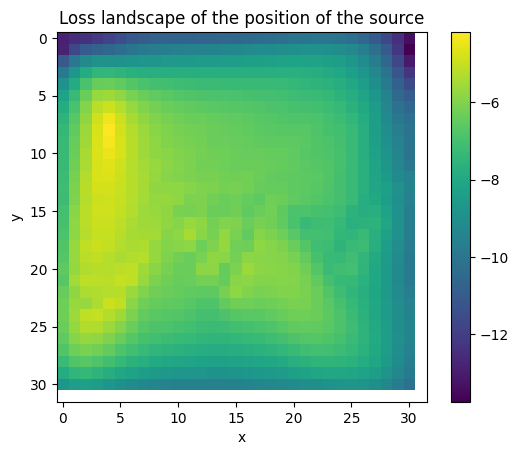

-4.1847105


In [16]:
plt.imshow(loss_landscape)
plt.colorbar()
plt.title("Loss landscape of the position of the source")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
print(jnp.amax(loss_landscape))

## Optimization loop

In [17]:
fargs = (src_coord, receiver_coords)
# fargs = [src_coord]

In [18]:
def loss_fn(fargs):
    objective = objective_function(fargs)
    return objective

In [19]:
loss_fn(fargs)

Array(-6.2643538, dtype=float32)

In [20]:
def grad(fargs):
    "Computes gradient of loss function wrt fargs"
    partial = lambda fargs: loss_fn(fargs)
    return eqx.filter_value_and_grad(partial)(fargs)

In [21]:
def step(fargs, opt_state, opt_update):
    lossval, grads = grad(fargs)

    # Print gradients for debugging
    print("Gradients in step function:")
    def print_grads(grads):
        def print_leaf(x):
            if x is None:
                print("None")
            else:
                print(x)
        jax.tree_util.tree_map(print_leaf, grads)
    
    print_grads(grads)
    # grads = (-grads[0], -grads[1])
    updates, opt_state = opt_update(grads, opt_state)
    fargs = eqx.apply_updates(fargs, updates)
    
    # Define the domain boundaries (adjust as necessary)
    x_min, x_max = 0.1, sound_speed.shape[1] - 1.1
    y_min, y_max = 0.1, sound_speed.shape[0] - 1.1

    # Clip the positions of the sources and receivers with respect to the pml_size
    x_min, x_max = pml_size * dx[0]*0.1 + 1.1, sound_speed.shape[1] - (pml_size * dx[0]*0.1 + 1.1)
    y_min, y_max = pml_size * dx[1]*0.1 + 1.1, sound_speed.shape[0] - (pml_size * dx[1]*0.1 + 1.1)
    
    # Clip the positions of the sources and receivers
    fargs = (
        jnp.array([[jax.tree_util.tree_map(lambda x: jnp.clip(x, y_min, y_max), fargs[0][0][0]),
        jax.tree_util.tree_map(lambda x: jnp.clip(x, x_min, x_max), fargs[0][0][1])]]),
        jnp.array([[jax.tree_util.tree_map(lambda x: jnp.clip(x, y_min, y_max), fargs[1][1][0]),
        jax.tree_util.tree_map(lambda x: jnp.clip(x, x_min, x_max), fargs[1][1][1])]]) 
    )
    # replace the receriver coords by fix value
    fargs = (fargs[0], receiver_coords)
    
    return lossval, fargs, opt_state, grads


In [22]:
optimiser = optax.adam(learning_rate=0.9)
opt_state = optimiser.init(eqx.filter(fargs, eqx.is_array))
opt_update = optimiser.update
n_steps = 200

print("Initial source and receiver coordinates:", fargs)
# print("Initial optimizer state:", opt_state)

Initial source and receiver coordinates: (Array([[16.01, 16.01]], dtype=float32), Array([[8.1, 4.1]], dtype=float32))


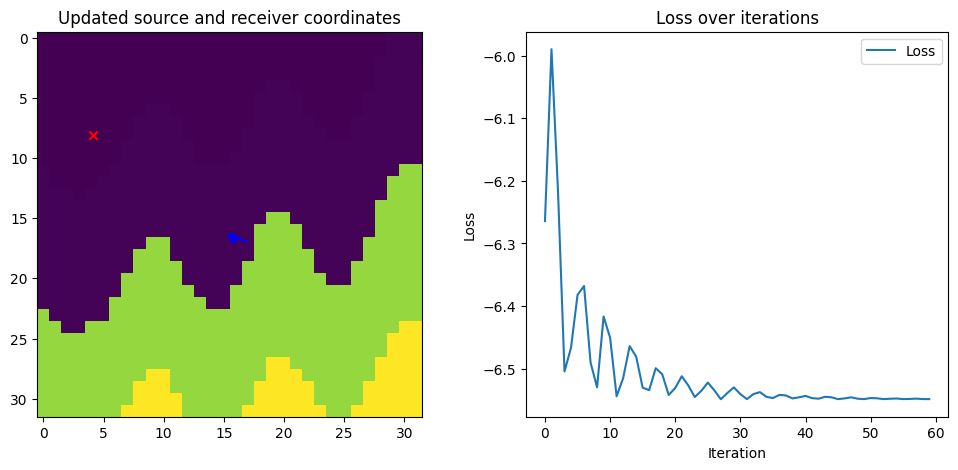

KeyboardInterrupt: 

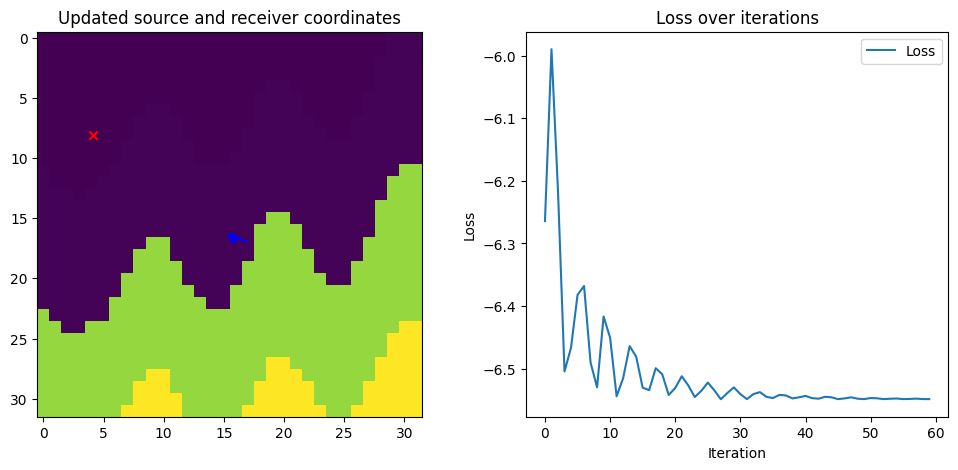

In [23]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time  # Optional, to simulate time between iterations

# Create the figure and two subplots outside the loop
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lossvals = []
source_trajectories = []
receiver_trajectories = []

for i in range(n_steps):
    tic = time.time()

    lossval, fargs, opt_state, grads = step(fargs, opt_state, opt_update)
    lossvals.append(lossval)
    tac = time.time()
    print(f"Step {i}, Loss: {lossval}, Time: {tac - tic}")

    # Record the current positions of sources and receivers
    source_trajectories.append((fargs[0][0][0], fargs[0][0][1]))  # Source
    receiver_trajectories.append((fargs[1][1][0], fargs[1][1][1]))  # Receiver
    # receiver_trajectories.append(receiver_coords[0],receiver_coords[1])  # Receiver

    # Clear the current axes, keeping the figure intact
    ax1.cla()
    ax2.cla()

    if i % 1 == 0:
        print(f"Step {i}, Loss: {lossval}")

        # Plot the sound speed on the first subplot
        im = ax1.imshow(sound_speed)
        ax1.set_title("Updated source and receiver coordinates")

        # Plot the trajectories of the sources and receivers
        source_positions = list(zip(*source_trajectories))
        receiver_positions = list(zip(*receiver_trajectories))
        ax1.plot(source_positions[1], source_positions[0], 'b-', label='Source Trajectory')
        ax1.plot(receiver_positions[1], receiver_positions[0], 'r-', label='Receiver Trajectory')

        # Plot the current positions of the source and receiver
        ax1.scatter(fargs[0][0][1], fargs[0][0][0], marker='*', color='blue', label='Current Source Position')
        # ax1.scatter(fargs[1][1][1], fargs[1][1][0], marker='x', color='red', label='Current Receiver Position')
        ax1.scatter(*receiver_coords.T[::-1], color='r', marker='x')
        # ax1.scatter(receiver_coords[1], receiver_coords[0], marker='o', color='blue', label='Current Receiver Position')

        print(fargs)

        # ax1.legend()

        # Plot the loss values over time on the second subplot
        ax2.plot(lossvals, label='Loss')
        ax2.set_title("Loss over iterations")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Loss")
        ax2.legend()
    
        # Update the plot display
        # clear_output(wait=True)
        # display(fig)
        # plt.savefig(f"opti_movie/step_{i}.png")

        # Force a draw before saving and displaying the figure
        fig.canvas.draw()

        # Save the figure after drawing everything
        # plt.savefig(f"opti_movie/step_{i}.png")

        # Clear the output, display the updated figure
        clear_output(wait=True)
        display(fig)

        # Pause to allow plot to refresh
        time.sleep(0.1)


        # plt.pause(0.01)  # Slight pause to allow plot to update
        # time.sleep(0.1)  # Optional, simulates time between iterations

# Show the final plot
plt.show()

print("Final Loss:", lossvals[-1])


In [ ]:
from PIL import Image
import os

# Path to the folder containing the images
image_folder = 'opti_movie'
output_gif = 'opti_movie_normalize_trace.gif'

# Get all images from the folder, assuming they are named as 'step_#.png'
images = [img for img in os.listdir(image_folder) if img.startswith("step_") and img.endswith(".png")]
images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by the number after 'step_'

# Load all images into a list
frames = [Image.open(os.path.join(image_folder, img)) for img in images]

# Save as an animated GIF
frames[0].save(output_gif, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=250,  # 250ms between frames (adjust FPS here)
               loop=0)  # loop=0 means infinite loop

print(f"GIF saved as {output_gif}")``